In [1]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Advanced modelling using Catboost

In this notebook we will model the car prices using Catboost. As we've seen exploring the data, we are dealing with a dataset containing multiple categorical variables sometimes with very high cardinality (e.g model of the car) and with a high proportion of missing values.

As we saw with the base model and the linear regression we were forced to fit models on groups of cars by model and brand and sometimes registration year. The problem encountered with these methods were that for groups with very few observations we could not fit a model on the desired level of group granularity and therefore had to fit the model on  a broader group (for example a porsche 918 would have to be estimated using a regression fitted on all porsches since there weren't enough of these cars in the dataset. This lead to worse estimations for car models which are not present enough in the dataset.

Moreover, with linear regressions we were limited to using variables which displayed a somehow linear relationship with the price, however not all independent variables in our dataset have a linear relationship with the price (for example the latitude and the longitude).

Ensemble methods such as Random Forests and Gradient boosting, based on fitting regression trees are still today the leading methods for tabular datasets. Their advantage is their ability to capture complex relationships, handle categorical variables efficiently while remaining very interpretable (although gradient boosted trees aren't as interpretable as compared to random forests).

In our case gradient boosting and specifically Catboost seems like an ideal method. In fact Catboost is a gradient boosting algorithm which is tailored to datasets with sparts categorical features with high cardinality which it treats via an advanced version of target encoding (consisting of assigning the mean value of the target for each category level. It also handles missing values, treating them as a separate category.

Some of these variables might intuitively have a great influence on the price of a car (for example the extras) however simple imputation methods for these variables would affect the structure of the data. In fact for the extras the NaN value means that we do not know if the car has this extra or not and therefore these should be  treated as a separate category.



In [2]:
train = pd.read_csv('../data/train_02032024.csv',index_col=0)
test = pd.read_csv('../data/test_02032024.csv',index_col=0)

In [3]:
cols_to_drop = [x for x in train.columns if 'option' in x]
cols_to_drop_2 = [
    'uuid',
    'label',
    'model_stub',
    'thumbs',
    'price_debatable',
    'user_id',
    'title',
    'without_vat',
    'seller',
    'created',
    'seo_json_ld',
    'address_long',
    'modified',
    'battery_range',
    'variant',
    'trim',
    'lat',
    'lon',
    'registration_month'
]

In [4]:
def create_groups(data):
    data['group_model_year_level'] = data['brand'] + '_' + data['model'] + '_' + data['registration_year'].astype(int).astype(str)
    data['group_model_level'] = data['brand'] + '_' + data['model']
    data['group_year_level'] = data['brand'] + '_' + data['registration_year'].astype(int).astype(str)
    return data

def drop_unwanted_columns(data):
    data = data.drop(columns = cols_to_drop + cols_to_drop_2).copy()
    return data

def split_data_to_validation(train_set):
    return train_test_split(train_set, test_size=0.2, random_state=42)

In [5]:
train, test = drop_unwanted_columns(train), drop_unwanted_columns(test)
train_val, val = split_data_to_validation(train)

#  Method: using all extras

In [6]:
train_val.columns

Index(['lat', 'lon', 'is_new', 'id', 'descriptive_title', 'mileage', 'crashed',
       'raw_price', 'engine_size', 'registration_month', 'registration_year',
       'engine_power', 'fuel_type', 'gearbox_type', 'brand', 'model',
       'description', 'extra_turbo', 'extra_steering_lights',
       'extra_collision_avoidance_system', 'extra_trip_computer',
       'extra_wheelchair', 'extra_apple_carplay', 'extra_leather_seats',
       'extra_anti_theft_system_gps', 'extra_rain_sensor',
       'extra_panoramic_roof', 'extra_dvd', 'extra_automatic_parking',
       'extra_multi_purpose_steering_wheel', 'extra_tcs_asr',
       'extra_tv_camera', 'extra_power_windows', 'extra_bucket_seats',
       'extra_hitch', 'extra_aircondition(a_c)', 'extra_heated_seats',
       'extra_power_seats', 'extra_alumium_rims', 'extra_locking_differential',
       'extra_android_auto', 'extra_roof_rails', 'extra_armored',
       'extra_lane_assist', 'never_crashed', 'extra_immobilizer',
       'extra_rear_view_c

In [7]:
cols_to_drop_for_train_predict = ['id', 'descriptive_title',
       'raw_price','description']

In [8]:
train_val['fuel_consumption'] = train_val['fuel_consumption'].astype(str).str.replace(',','.').astype(float)
train_val['battery_charge_time'] = train_val['battery_charge_time']
train_val['registration_year'] = train_val['registration_year'].astype(float) #We saw the ordinal relationship of year with the price so we will treat is as a numerical variable




In [70]:
test['fuel_consumption'] = test['fuel_consumption'].astype(str).str.replace(',','.').astype(float)
test['battery_charge_time'] = test['battery_charge_time']
test['registration_year'] = test['registration_year'].astype(float) #We saw the ordinal relationship of year with the price so we will treat is as a numerical variable
test['battery_charge_time'] = test['battery_charge_time']



In [9]:
val['fuel_consumption'] = val['fuel_consumption'].astype(str).str.replace(',','.').astype(float)
val['acceleration'] = val['acceleration'].astype(str).str.replace(',','.').astype(float)
val['battery_charge_time'] = val['battery_charge_time']
val['registration_year'] = val['registration_year'].astype(float) #We saw the ordinal relationship of year with the price so we will treat is as a numerical variable


In [10]:
numerical_features = train_val.drop(columns=cols_to_drop_for_train_predict).select_dtypes(include=['float']).columns.tolist()

In [11]:
categorical_features = train_val.drop(columns=cols_to_drop_for_train_predict).select_dtypes(include=['object','category','int','bool']).columns.tolist()

In [12]:
categorical_features

['is_new',
 'crashed',
 'registration_month',
 'fuel_type',
 'gearbox_type',
 'brand',
 'model',
 'extra_turbo',
 'extra_steering_lights',
 'extra_collision_avoidance_system',
 'extra_trip_computer',
 'extra_wheelchair',
 'extra_apple_carplay',
 'extra_leather_seats',
 'extra_anti_theft_system_gps',
 'extra_rain_sensor',
 'extra_panoramic_roof',
 'extra_dvd',
 'extra_automatic_parking',
 'extra_multi_purpose_steering_wheel',
 'extra_tcs_asr',
 'extra_tv_camera',
 'extra_power_windows',
 'extra_bucket_seats',
 'extra_hitch',
 'extra_aircondition(a_c)',
 'extra_heated_seats',
 'extra_power_seats',
 'extra_alumium_rims',
 'extra_locking_differential',
 'extra_android_auto',
 'extra_roof_rails',
 'extra_armored',
 'extra_lane_assist',
 'never_crashed',
 'extra_immobilizer',
 'extra_rear_view_camera',
 'extra_air_suspension',
 'extra_bluetooth',
 'extra_parktronic',
 'extra_isofix_children_seats',
 'extra_electric_sunroof',
 'extra_abs',
 'extra_telephone',
 'extra_led_lights',
 'extra_gps'

In [13]:
numerical_features

['lat',
 'lon',
 'mileage',
 'engine_size',
 'registration_year',
 'engine_power',
 'seats',
 'emissions_co2',
 'battery_charge_time',
 'rim_size',
 'vehicle_height',
 'number_of_gears',
 'torque',
 'gross_weight',
 'acceleration',
 'vehicle_width',
 'vehicle_length',
 'top_speed',
 'wheelbase',
 'fuel_consumption',
 'doors']

In [14]:
cols_for_predict = train.drop(columns=cols_to_drop_for_train_predict).columns.tolist()

In [15]:
X_val = train_val.drop(columns=cols_to_drop_for_train_predict)

In [16]:
X_test_val = val.drop(columns=cols_to_drop_for_train_predict)

In [71]:
X_test_for_pred = test.drop(columns=cols_to_drop_for_train_predict)

In [17]:
cols_for_predict = [X_val.columns.get_loc(x) for x in cols_for_predict]
numerical_features = [X_val.columns.get_loc(x) for x in numerical_features]
categorical_features = [X_val.columns.get_loc(x) for x in categorical_features]

In [18]:
X_val.iloc[:,categorical_features] = X_val.iloc[:,categorical_features].fillna("nan")

In [19]:
X_test_val.iloc[:,categorical_features] = X_test_val.iloc[:,categorical_features].fillna("nan")

In [72]:
X_test_for_pred.iloc[:,categorical_features] = X_test_for_pred.iloc[:,categorical_features].fillna("nan")

In [189]:
categorical_features

[2,
 4,
 6,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 72,
 73,
 74,
 77,
 85,
 90,
 92]

In [23]:
train_val_set = Pool(data = X_val , cat_features = categorical_features, label= train_val.raw_price)

In [24]:
test_val_set = Pool(data = X_test_val , cat_features = categorical_features, label= val.raw_price)

In [73]:
test_set = Pool(data = X_test_for_pred , cat_features = categorical_features, label= test.raw_price)

In [25]:
catboost = CatBoostRegressor(loss_function='MAE', iterations=1000, learning_rate=0.2, max_depth=8 , nan_mode='Max')

In [26]:
catboost.fit(train_val_set,eval_set=test_val_set, early_stopping_rounds=100, verbose=100)


0:	learn: 7668.8090397	test: 7826.9893217	best: 7826.9893217 (0)	total: 222ms	remaining: 3m 41s
100:	learn: 2201.0826484	test: 2415.1025550	best: 2415.1025550 (100)	total: 18.6s	remaining: 2m 45s
200:	learn: 1940.2777187	test: 2285.5000678	best: 2285.5000678 (200)	total: 39.8s	remaining: 2m 38s
300:	learn: 1834.3336038	test: 2255.4358078	best: 2254.8336916 (296)	total: 1m	remaining: 2m 21s
400:	learn: 1767.3416586	test: 2245.6172414	best: 2245.6172414 (400)	total: 1m 23s	remaining: 2m 4s
500:	learn: 1716.7595365	test: 2237.5301445	best: 2237.4814196 (496)	total: 1m 45s	remaining: 1m 45s
600:	learn: 1674.0405513	test: 2232.5535702	best: 2232.5535702 (600)	total: 2m 7s	remaining: 1m 24s
700:	learn: 1641.7756220	test: 2230.1537827	best: 2229.1255379 (692)	total: 2m 29s	remaining: 1m 3s
800:	learn: 1611.6010294	test: 2226.7192546	best: 2226.7192546 (800)	total: 2m 51s	remaining: 42.5s
900:	learn: 1580.8938465	test: 2225.7071042	best: 2225.6846566 (899)	total: 3m 13s	remaining: 21.2s
999:	l

In [27]:
predictions = catboost.predict(test_val_set)

In [28]:
pd.DataFrame({'features' : X_val.columns, 'importance': catboost.get_feature_importance()}).sort_values(by='importance',ascending=False)

,features,importance
8,engine_power,22.728633
7,registration_year,17.979607
5,engine_size,12.161265
11,brand,10.877451
90,drive_type,5.216178
...,...,...
28,extra_power_windows,0.032449
53,extra_central_locking,0.030786
20,extra_anti_theft_system_gps,0.029855
57,extra_head_up_display,0.027019


In [30]:
results = val.copy()

In [31]:
results['prediction'] = predictions
results['residuals'] = results['raw_price'] - predictions
results['abs_residuals'] = abs(results['raw_price'] - predictions)
results['ape'] = abs(results['raw_price'] - predictions)/results['raw_price']

In [32]:
results.ape.mean()

0.15944952210022778

In [33]:
results.ape.describe([0.01,0.05,0.1,0.25,0.5,0.75,0.90,0.95,0.975,0.99])

count    16229.000000
mean         0.159450
std          0.443703
min          0.000003
1%           0.001655
5%           0.007880
10%          0.016060
25%          0.042422
50%          0.095094
75%          0.186140
90%          0.325304
95%          0.461991
97.5%        0.665455
99%          1.041044
max         45.218287
Name: ape, dtype: float64

In [34]:
results.abs_residuals.describe([0.01,0.05,0.1,0.25,0.5,0.75,0.90,0.95,0.975,0.99])

count     16229.000000
mean       2220.168681
std        5308.210578
min           0.032047
1%           18.202109
5%           83.864388
10%         168.096948
25%         434.191412
50%         998.953050
75%        2115.996205
90%        4473.498546
95%        7505.439780
97.5%     12170.494216
99%       21653.557013
max      164330.661237
Name: abs_residuals, dtype: float64

(0.0, 250000.0)

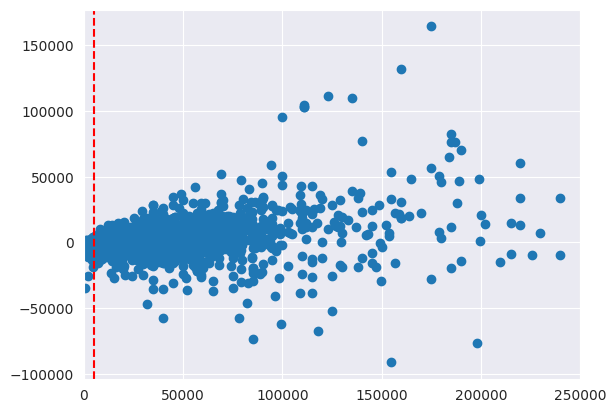

In [35]:
from matplotlib import pyplot as plt

plt.scatter(results.raw_price, results.residuals)
plt.axvline(5000,color='r',linestyle='--')
plt.xlim([0,250000])

(-10000.0, 10000.0)

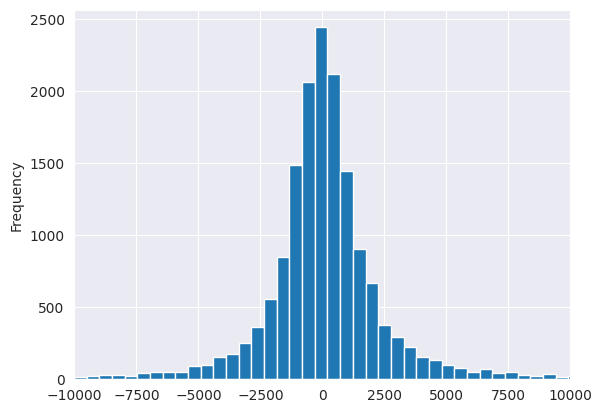

In [36]:
results.residuals.plot(kind='hist',bins=500, )
plt.xlim([-10000,10000])

In [38]:
results.loc[:,['brand','ape']].groupby('brand').agg('median').sort_values(by='ape',ascending=True)

,ape
brand,
renault,0.069811
dacia,0.070371
hyundai,0.072720
toyota,0.072739
nissan,0.073888
...,...
aston martin,0.572340
mclaren,0.589148
corvette,0.788154


In [39]:
brand_counts = train.brand.value_counts()
results['brand_counts'] = results['brand'].map(brand_counts)

(0.0, 1.0)

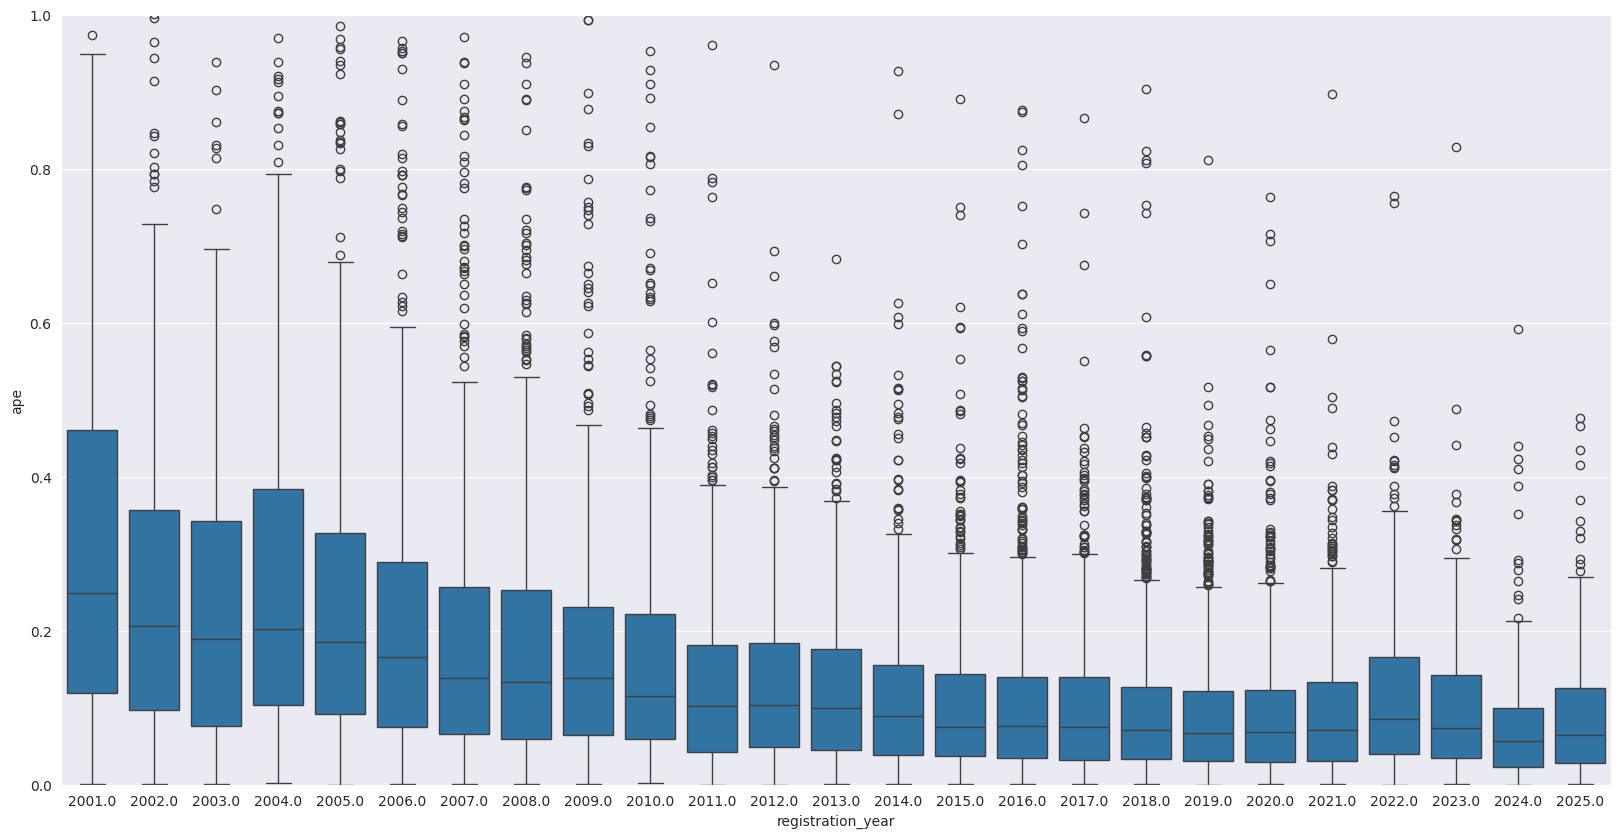

In [40]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.boxplot(x = results.registration_year, y= results.ape)
plt.ylim([0,1])

In [235]:
results.loc[:,['registration_year','ape']].groupby('registration_year')['ape'].apply(lambda x : x.describe([0.9,0.95])).unstack(0)

registration_year,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,...,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0,2024.0,2025.0
count,312.000000,383.000000,430.000000,553.000000,570.000000,645.000000,750.000000,726.000000,672.000000,458.000000,...,1305.000000,1223.000000,1180.000000,1250.000000,916.000000,673.000000,308.000000,273.000000,268.000000,170.000000
mean,0.419694,0.351504,0.283500,0.307741,0.247085,0.228407,0.202196,0.215037,0.178915,0.169067,...,0.102212,0.097709,0.095358,0.088054,0.094919,0.109127,0.118242,0.094447,0.274809,0.086795
std,0.706558,0.573854,0.370802,0.413614,0.290927,0.258455,0.249316,0.324579,0.212171,0.191463,...,0.111730,0.101829,0.141483,0.078986,0.110335,0.316278,0.139236,0.084582,3.216318,0.082706
min,0.001521,0.001141,0.002478,0.001127,0.000032,0.000421,0.000398,0.000028,0.000512,0.000096,...,0.000182,0.000081,0.000153,0.000031,0.000032,0.000060,0.000066,0.000135,0.000269,0.000492
50%,0.244275,0.209533,0.183026,0.189354,0.173132,0.156665,0.128368,0.135738,0.123607,0.116279,...,0.077392,0.073926,0.066779,0.065399,0.068977,0.068539,0.085836,0.072047,0.059231,0.066687
90%,0.803594,0.693503,0.587089,0.635129,0.501234,0.485035,0.430349,0.436266,0.363474,0.370261,...,0.208475,0.199495,0.200659,0.191906,0.207278,0.206603,0.242009,0.197547,0.172207,0.179319
95%,1.183777,0.979773,0.879904,0.924938,0.754411,0.705526,0.573330,0.629015,0.494899,0.539357,...,0.282774,0.269922,0.267769,0.251821,0.276723,0.269123,0.323612,0.256727,0.255320,0.243231
max,8.368516,6.253504,4.143100,4.188325,2.571015,2.344392,3.741592,4.539648,2.482249,1.481434,...,1.789500,1.452768,3.900502,0.659539,1.963120,6.672949,1.794308,0.552378,52.714387,0.526573


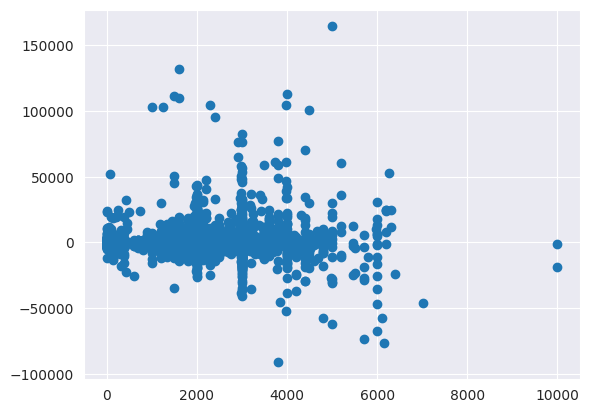

In [41]:
plt.scatter(results.engine_size, results.residuals)


In [247]:
results['pe'] = results.residuals/results.raw_price

(-10.0, 10.0)

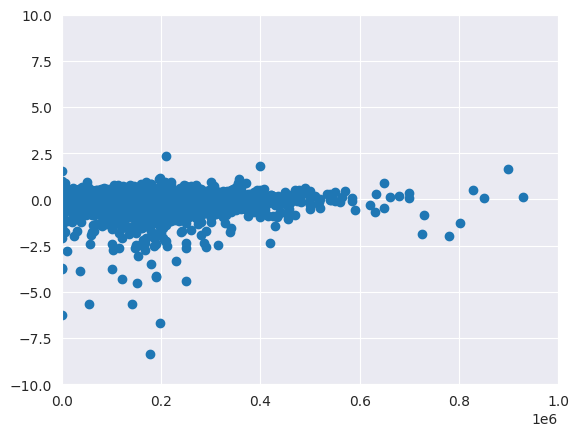

In [250]:
plt.scatter(results.mileage, results.pe)
plt.xlim([0,1000000])
plt.ylim([-10,10])


(0.0, 10000.0)

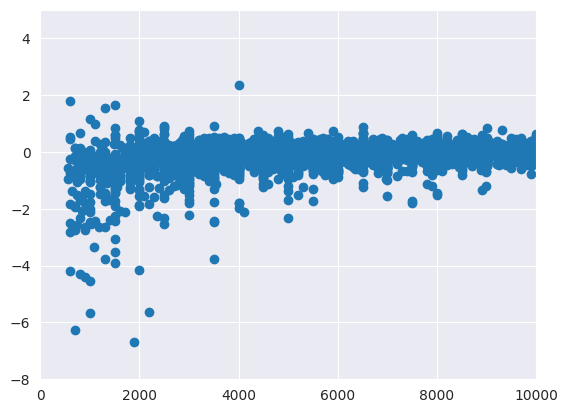

In [254]:
plt.scatter(results.raw_price,results.pe) #raw_price - pred
plt.ylim([-8,5])
plt.xlim([0,10000])

(0.0, 1.0)

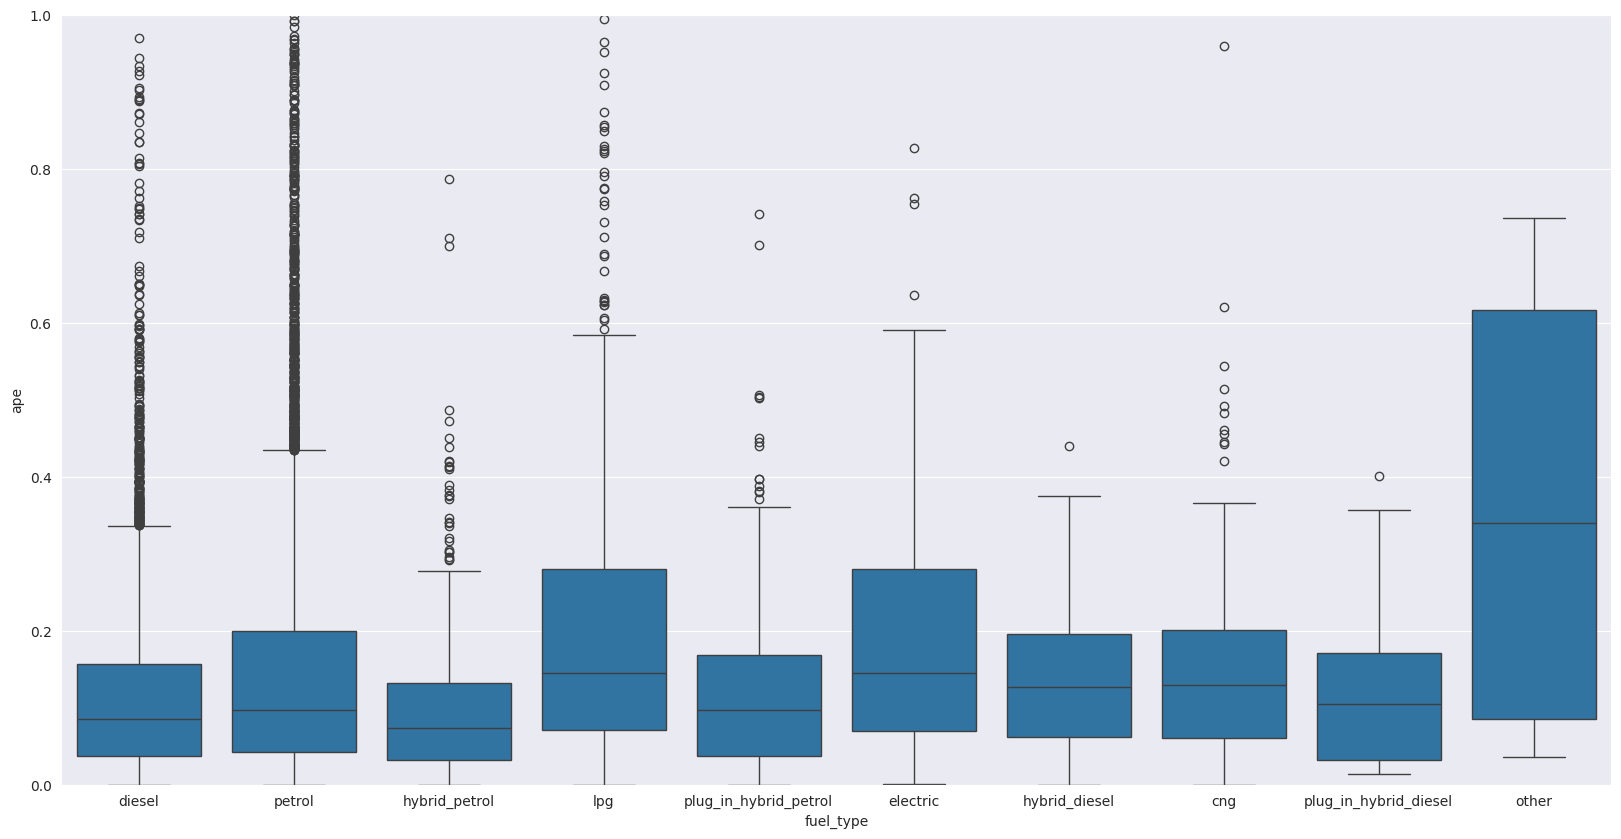

In [42]:
plt.figure(figsize=(20,10))
sns.boxplot(x= results.fuel_type, y=results.ape)
plt.ylim([0,1])

In [65]:
results.loc[(results.registration_year > 2011)&(results.fuel_type.isin(['diesel','petrol','hybrid_perol','hybrid_diesel','plug_in_hybrid_diesel','hybrid_plug_in_petrol']))&~(results.crashed)&(results.raw_price>2000)&(results.engine_size>600), 'ape'].describe([0.01,0.05,0.1,0.25,0.5,0.75,0.90,0.95,0.975,0.99])

count    8902.000000
mean        0.099762
std         0.103373
min         0.000013
1%          0.001366
5%          0.006117
10%         0.013011
25%         0.033100
50%         0.073189
75%         0.134423
90%         0.214623
95%         0.281526
97.5%       0.349824
99%         0.452257
max         2.191391
Name: ape, dtype: float64

In [64]:
restricted_results = results.loc[(results.registration_year > 2011)&(results.fuel_type.isin(['diesel','petrol','hybrid_perol','hybrid_diesel','plug_in_hybrid_diesel','hybrid_plug_in_petrol']))&~(results.crashed)&(results.raw_price>2000)].copy()

<Axes: xlabel='brand'>

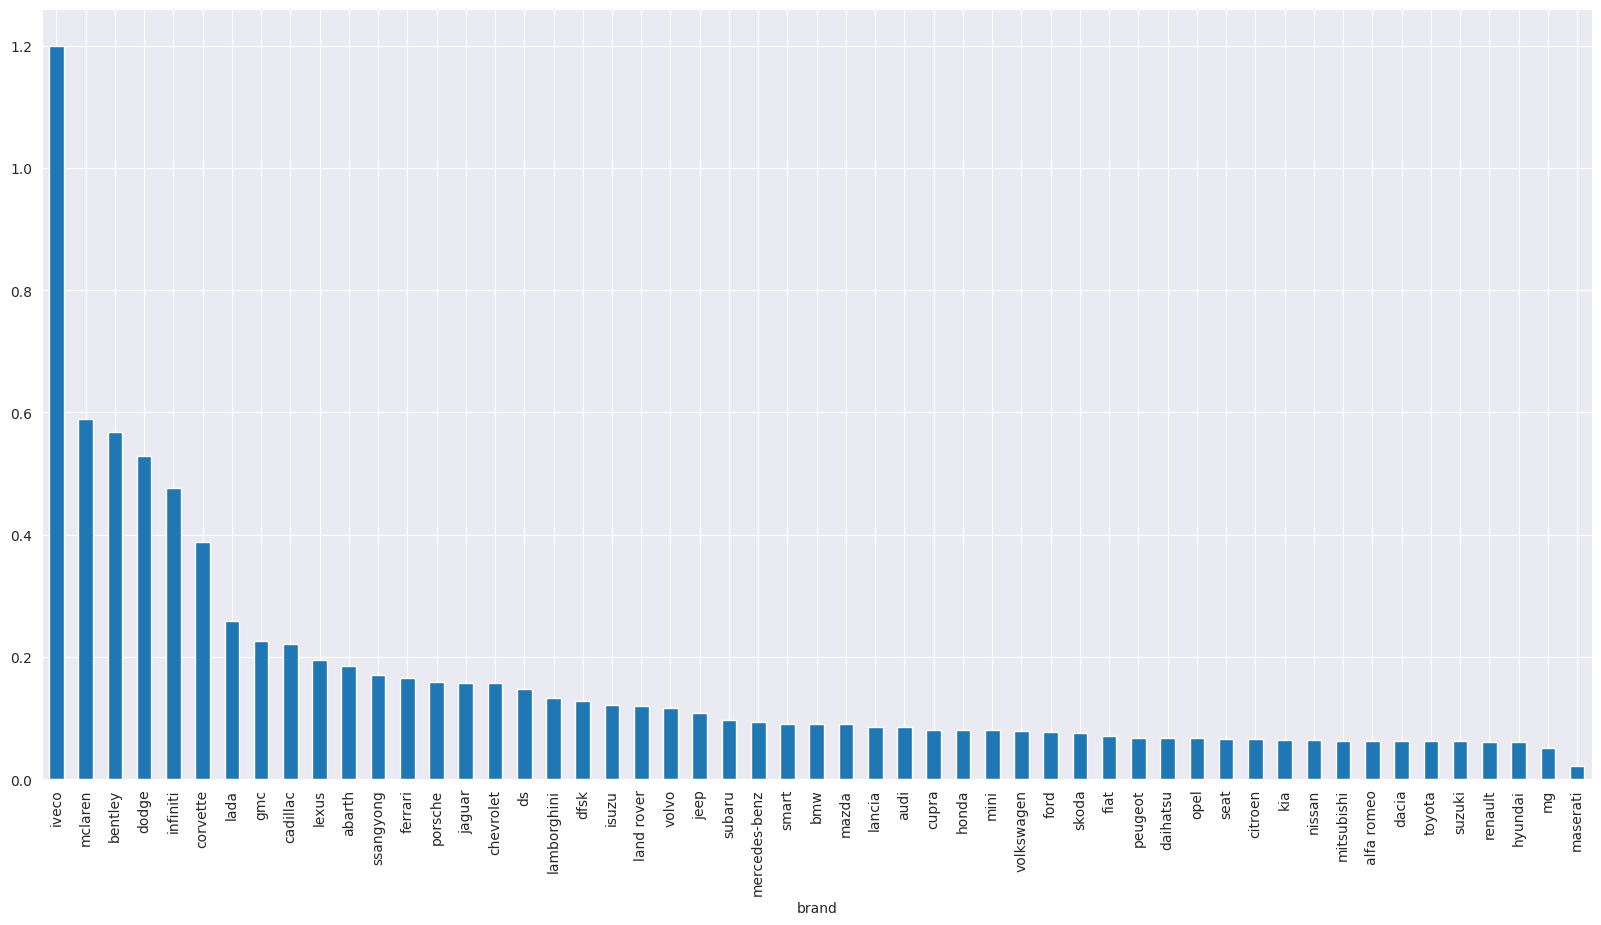

In [69]:
plt.figure(figsize=(20,10))

restricted_results.groupby('brand')['ape'].agg('median').sort_values(ascending=False).plot(kind='bar')

In [74]:
test_pred = catboost.predict(test_set)

In [75]:
test['prediction'] = test_pred
test['residuals'] = test['raw_price'] - test_pred
test['abs_residuals'] = abs(test['raw_price'] - test_pred)
test['ape'] = abs(test['raw_price'] - test_pred)/test['raw_price']

In [77]:
test.ape.describe([0.01, 0.05, 0.1, 0.25,0.5,0.75,0.90,0.95,0.975,0.99])

count    20286.000000
mean         0.162556
std          0.438053
min          0.000014
1%           0.001466
5%           0.008354
10%          0.016922
25%          0.043251
50%          0.095870
75%          0.188803
90%          0.332765
95%          0.470197
97.5%        0.647967
99%          1.056900
max         37.053588
Name: ape, dtype: float64

In [79]:
test.loc[(test.registration_year > 2011)&(test.fuel_type.isin(['diesel','petrol','hybrid_perol','hybrid_diesel','plug_in_hybrid_diesel','hybrid_plug_in_petrol']))&~(test.crashed)&(test.raw_price>2000),'ape'].describe([0.01, 0.05, 0.1, 0.25,0.5,0.75,0.90,0.95,0.975,0.99])

count    11204.000000
mean         0.102200
std          0.191811
min          0.000014
1%           0.001127
5%           0.006556
10%          0.013529
25%          0.033757
50%          0.072836
75%          0.133383
90%          0.212202
95%          0.272076
97.5%        0.347479
99%          0.469730
max         15.720054
Name: ape, dtype: float64

In [80]:
restricted_test = test.loc[(test.registration_year > 2011)&(test.fuel_type.isin(['diesel','petrol','hybrid_perol','hybrid_diesel','plug_in_hybrid_diesel','hybrid_plug_in_petrol']))&~(test.crashed)&(test.raw_price>2000)].copy()

In [81]:
restricted_test[restricted_test.ape> restricted_test.ape.quantile(0.99)]

,lat,lon,is_new,id,descriptive_title,mileage,crashed,raw_price,engine_size,registration_month,...,top_speed,wheelbase,fuel_consumption,drive_type,doors,is_metallic,prediction,residuals,abs_residuals,ape
32114,35.365257,24.437683,False,42846112,Bmw 530 '21 530d xDrive 4x4 Facelift M Sport...,75000.0,False,55000.0,3000.0,1,...,250.0,2975.0,5.1,RWD,5.0,False,82155.722844,-27155.722844,27155.722844,0.493740
47760,37.964734,23.663021,False,43644263,Skoda Octavia '13 - 5/2013 - 1 χλμ - Πετρέλαιο...,1.0,False,4000.0,2000.0,5,...,211.0,2575.0,4.8,FWD,5.0,True,9573.981013,-5573.981013,5573.981013,1.393495
3221,37.959240,23.735396,False,41396347,Mercedes-Benz C 43 AMG '20 4MATIC 9G-TRONIC! A...,92000.0,False,59000.0,3000.0,1,...,NaN,NaN,9.3,4WD,5.0,True,87169.125778,-28169.125778,28169.125778,0.477443
94043,38.726013,20.697178,False,342795245,Ford Ranger '15 - 1/2015 - 2.000 χλμ - Πετρέλα...,2000.0,False,20000.0,3200.0,1,...,NaN,NaN,10.0,4WD,4.0,False,31176.996931,-11176.996931,11176.996931,0.558850
92714,37.791393,24.021391,False,342214171,Audi S5 '18 - 9/2018 - 70.000 χλμ - Βενζίνη - ...,70000.0,False,33500.0,3000.0,9,...,NaN,NaN,NaN,4WD,4.0,False,90145.905266,-56645.905266,56645.905266,1.690923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73028,38.282592,21.831911,False,44390309,Skoda Rapid '14 1.6 TDI - 11/2014 - 155.000 χλ...,155000.0,False,8000.0,1600.0,11,...,NaN,NaN,NaN,NaN,5.0,False,12392.570322,-4392.570322,4392.570322,0.549071
74014,40.265015,23.310290,False,317019196,Volkswagen Caddy '12 - 11/2012 - 122.000 χλμ -...,122000.0,False,8000.0,3000.0,11,...,NaN,NaN,NaN,NaN,4.0,False,14994.297139,-6994.297139,6994.297139,0.874287
95827,38.168542,23.738051,False,343527042,Mercedes-Benz B 200 '14 - 11/2014 - 205.000 χλ...,205000.0,False,13800.0,1991.0,11,...,NaN,NaN,NaN,FWD,5.0,True,20338.329714,-6538.329714,6538.329714,0.473792
83425,35.337978,25.166259,False,337267503,"Chevrolet Cruze '14 CHEVROLET CRUSE 1,6 AUTOMA...",140000.0,False,5200.0,1600.0,5,...,NaN,NaN,NaN,FWD,5.0,False,8381.759157,-3181.759157,3181.759157,0.611877


In [83]:
# Analyse behaviour of the model
dict_car = X_test_for_pred.iloc[0].to_dict()

In [84]:
dict_car

{'lat': 37.9677948168,
 'lon': 23.6177911107,
 'is_new': False,
 'mileage': 30000.0,
 'crashed': False,
 'engine_size': 1968.0,
 'registration_month': 1,
 'registration_year': 2022.0,
 'engine_power': 205.0,
 'fuel_type': 'hybrid_diesel',
 'gearbox_type': 'automatic',
 'brand': 'audi',
 'model': 'a4',
 'extra_turbo': True,
 'extra_steering_lights': True,
 'extra_collision_avoidance_system': True,
 'extra_trip_computer': True,
 'extra_wheelchair': False,
 'extra_apple_carplay': True,
 'extra_leather_seats': False,
 'extra_anti_theft_system_gps': False,
 'extra_rain_sensor': True,
 'extra_panoramic_roof': False,
 'extra_dvd': True,
 'extra_automatic_parking': False,
 'extra_multi_purpose_steering_wheel': True,
 'extra_tcs_asr': True,
 'extra_tv_camera': False,
 'extra_power_windows': True,
 'extra_bucket_seats': True,
 'extra_hitch': False,
 'extra_aircondition(a_c)': False,
 'extra_heated_seats': False,
 'extra_power_seats': False,
 'extra_alumium_rims': True,
 'extra_locking_differenti

In [101]:
def pdp_num(X_test_set, feature, model):
    min_val = X_test_set[feature].min()
    max_val = X_test_set[feature].max()
    new_set = X_test_set.copy()
    range_vals = np.linspace(min_val,max_val,20)
    predictions = []
    for val in range_vals:
        new_set[feature] = val
        preds = model.predict(new_set)
        predictions.append(preds.mean())
    plt.plot(range_vals, predictions)
    plt.title('PDP for feature {}'.format(feature))
    return predictions


def pdp_cat(X_test_set, feature, model):
    new_set = X_test_set.copy()
    range_vals = new_set[feature].unique()
    predictions = []
    vals = []
    for val in range_vals:
        new_set[feature] = val
        preds = model.predict(new_set)
        predictions.append(preds.mean())
        vals.append(str(val))
    df = pd.DataFrame({'cats':vals, 'pred_average': predictions}).sort_values(by='pred_average', ascending=False)
    plt.bar(df.cats, df.pred_average)
    plt.title('PDP for feature {}'.format(feature))
    return predictions



[15870.510091902606,
 16374.346307670821,
 14533.873868585722,
 12946.850781777546,
 12086.447026940627,
 11642.332629628312,
 11368.740624071726,
 11067.725383200719,
 11067.725383200719,
 11067.725383200719,
 11067.725383200719,
 11067.725383200719,
 11067.725383200719,
 11067.725383200719,
 11067.725383200719,
 11067.725383200719,
 11067.725383200719,
 11067.725383200719,
 11067.725383200719,
 11067.725383200719]

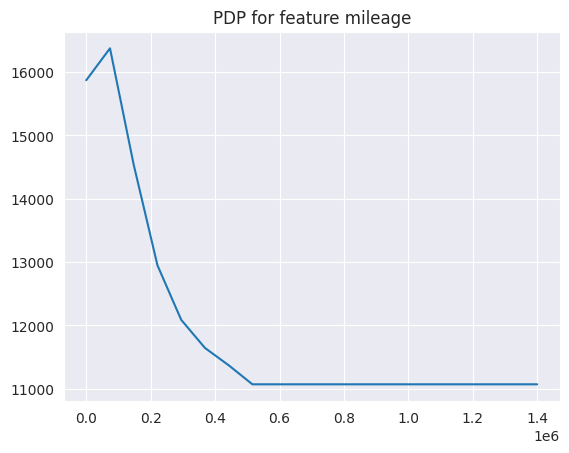

In [88]:
pdp(X_test_for_pred, 'mileage', catboost)

[6775.260586944082,
 6832.888636042681,
 7727.60977017369,
 8004.102269518272,
 8540.43170957822,
 9331.019422442228,
 10539.500716478358,
 11677.37066273257,
 12153.167870455532,
 12939.109176960908,
 15002.694823508618,
 15994.143707542977,
 16991.376674824485,
 17730.46639786623,
 19724.244768990582,
 21301.841364037755,
 22262.139510074736,
 24155.230762651096,
 26050.158881360763,
 26050.158881360763]

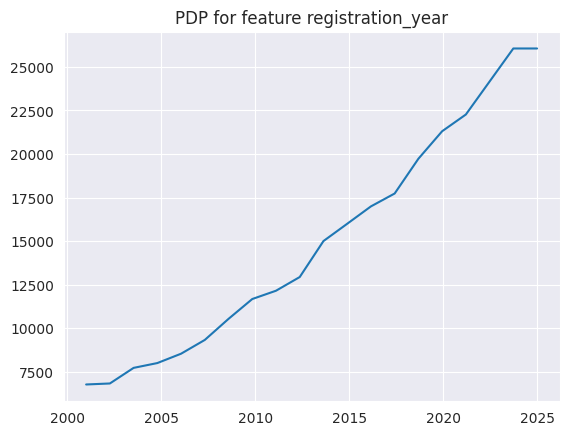

In [89]:
pdp(X_test_for_pred, 'registration_year', catboost)

[15558.634598774684, 8422.136998509775]

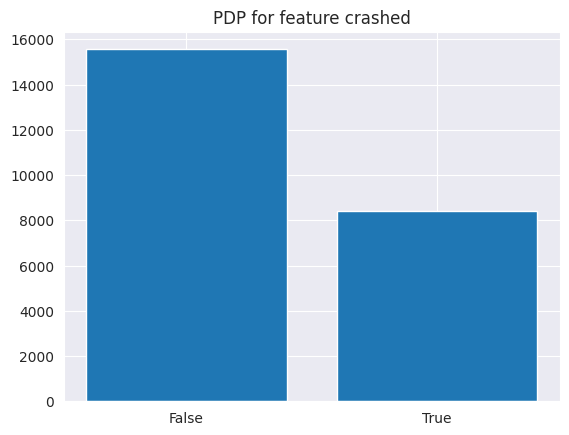

In [98]:
pdp_cat(X_test_for_pred, 'crashed', catboost)

[14232.294164275037,
 13702.9327189942,
 13682.542404450656,
 14441.313507780125,
 16248.076908893341,
 18663.10874577984,
 20216.053938957128,
 21000.889632296807,
 29957.91109160397,
 29896.63163750526,
 41906.19233459013,
 40623.32061735625,
 40623.32061735625,
 40623.32061735625,
 40623.32061735625,
 40623.32061735625,
 40623.32061735625,
 40623.32061735625,
 40623.32061735625,
 40623.32061735625]

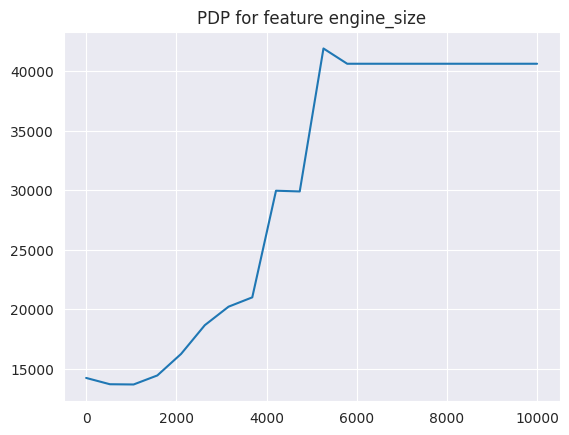

In [99]:
pdp_num(X_test_for_pred, 'engine_size', catboost)

[15318.36765670495,
 15604.465823400467,
 15504.524200627311,
 15524.744122802009,
 15543.239039511058,
 15514.343763415858,
 15619.07505814852,
 15528.806035566724,
 15613.66038725056,
 15507.740067838595,
 15591.995077928726,
 15537.316706477206]

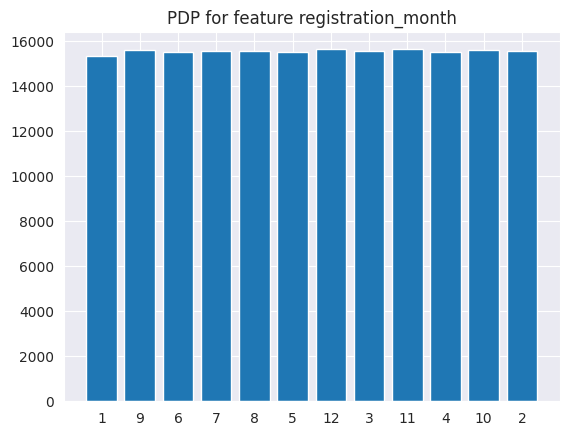

In [100]:
pdp_cat(X_test_for_pred, 'registration_month', catboost)

[15635.150740302426,
 15130.00748251078,
 15968.388274439047,
 15487.522125672276,
 14983.135749548357,
 15197.121974886199,
 15676.069389683122,
 15800.538290214285,
 16475.833770167457,
 16441.702634673307,
 15696.31863518451]

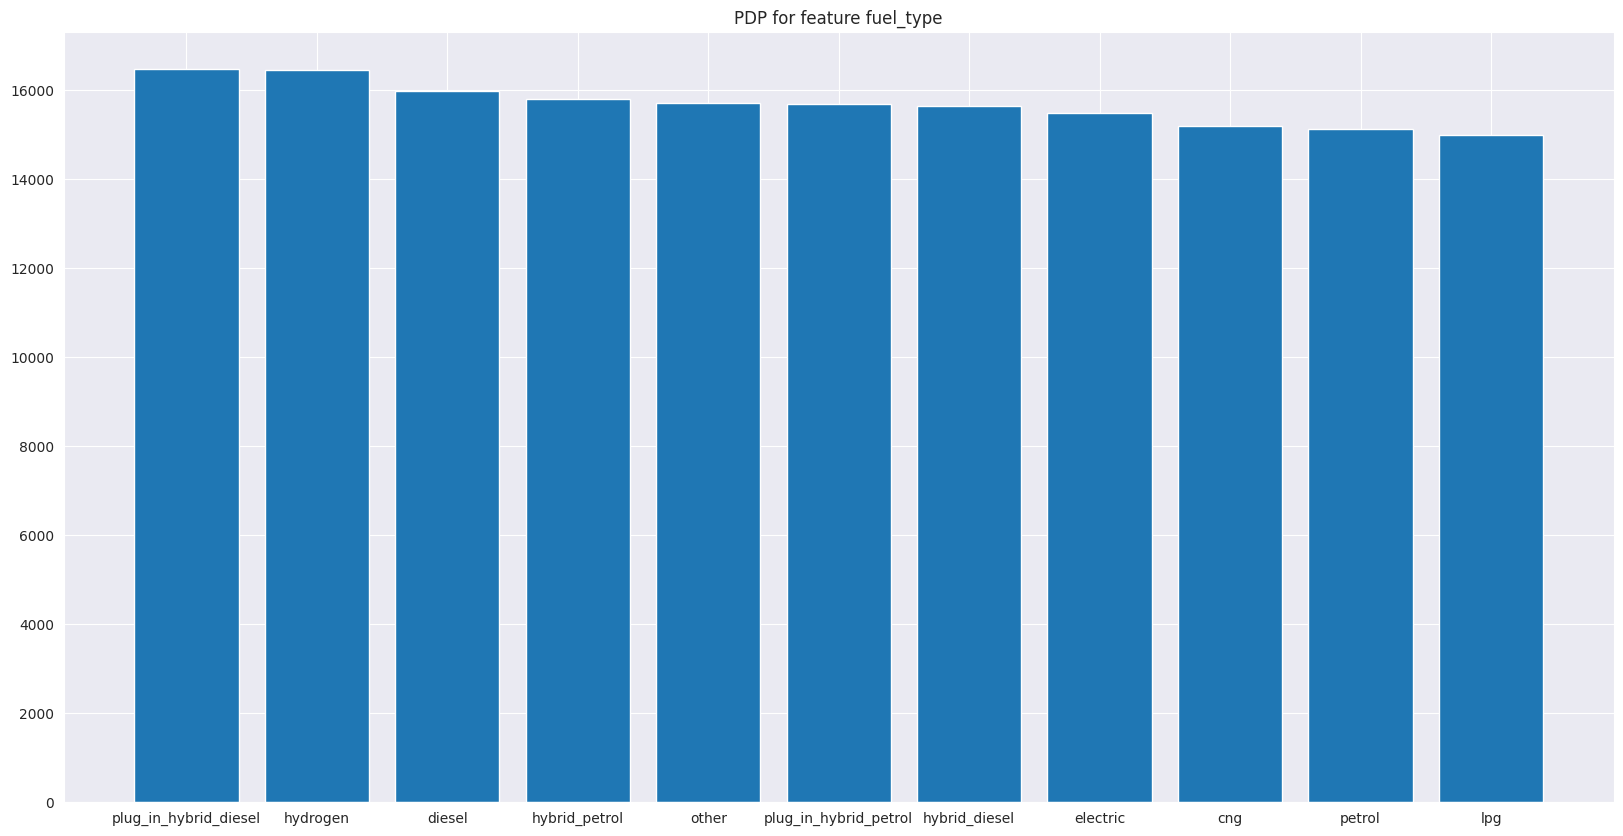

In [103]:
plt.figure(figsize=(20,10))
pdp_cat(X_test_for_pred, 'fuel_type', catboost)

[16259.836825151606, 14756.067387397923, 15755.666733076252]

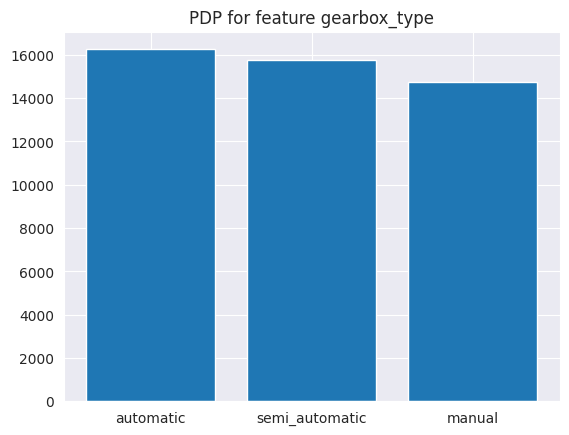

In [104]:
pdp_cat(X_test_for_pred, 'gearbox_type', catboost)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68],
 [Text(0, 0, 'porsche'),
  Text(1, 0, 'land rover'),
  Text(2, 0, 'mercedes-benz'),
  Text(3, 0, 'audi'),
  Text(4, 0, 'bmw'),
  Text(5, 0, 'jeep'),
  Text(6, 0, 'volvo'),
  Text(7, 0, 'jaguar'),
  Text(8, 0, 'maserati'),
  Text(9, 0, 'cupra'),
  Text(10, 0, 'isuzu'),
  Text(11, 0, 'ds'),
  Text(12, 0, 'abarth'),
  Text(13, 0, 'hummer'),
  Text(14, 0, 'iveco'),
  Text(15, 0, 'ferrari'),
  Text(16, 0, 'dfsk'),
  Text(17, 0, 'toyota'),
  Text(18, 0, 'lynk&co'),
  Text(19, 0, 'honda'),
  Text(20, 0, 'mg'),
  Text(21, 0, 'dacia'),
  Text(22, 0, 'infiniti'),
  Text(23, 0, 'aston martin'),
  Te

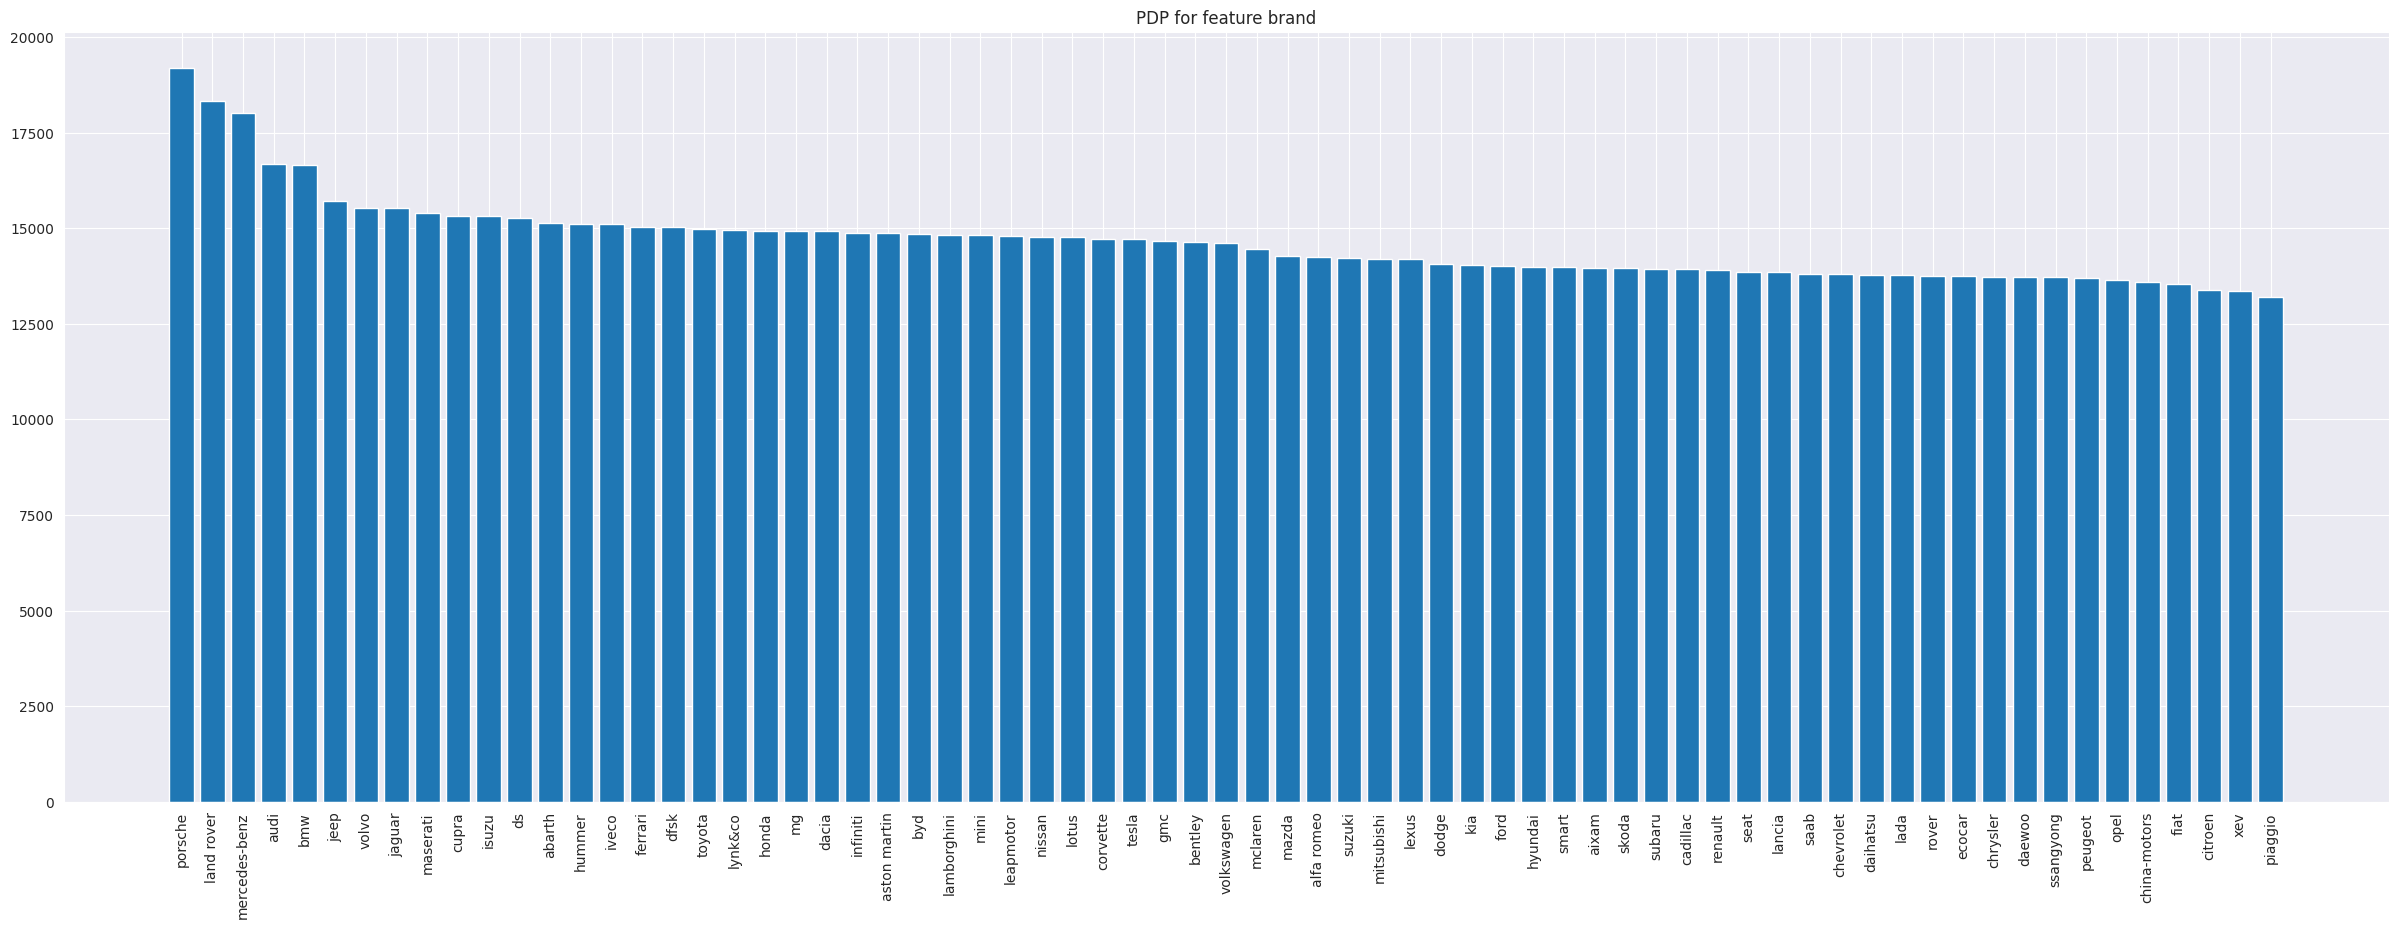

In [109]:
plt.figure(figsize=(30,10))
pdp_cat(X_test_for_pred, 'brand', catboost)
plt.xticks(rotation=90, fontsize=10)

In [110]:
catboost.save_model('../data/models/catboost_extras')

[15524.912068244768, 15566.934945801911, 15479.719259906362]

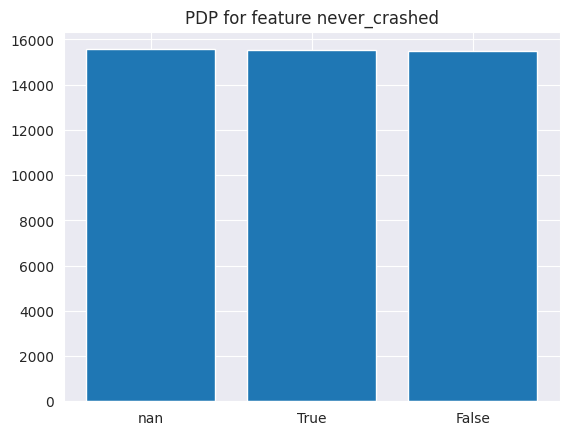

In [121]:
pdp_cat(X_test_for_pred, 'never_crashed', catboost)

In [114]:
catboost.feature_names_

['lat',
 'lon',
 'is_new',
 'mileage',
 'crashed',
 'engine_size',
 'registration_month',
 'registration_year',
 'engine_power',
 'fuel_type',
 'gearbox_type',
 'brand',
 'model',
 'extra_turbo',
 'extra_steering_lights',
 'extra_collision_avoidance_system',
 'extra_trip_computer',
 'extra_wheelchair',
 'extra_apple_carplay',
 'extra_leather_seats',
 'extra_anti_theft_system_gps',
 'extra_rain_sensor',
 'extra_panoramic_roof',
 'extra_dvd',
 'extra_automatic_parking',
 'extra_multi_purpose_steering_wheel',
 'extra_tcs_asr',
 'extra_tv_camera',
 'extra_power_windows',
 'extra_bucket_seats',
 'extra_hitch',
 'extra_aircondition(a_c)',
 'extra_heated_seats',
 'extra_power_seats',
 'extra_alumium_rims',
 'extra_locking_differential',
 'extra_android_auto',
 'extra_roof_rails',
 'extra_armored',
 'extra_lane_assist',
 'never_crashed',
 'extra_immobilizer',
 'extra_rear_view_camera',
 'extra_air_suspension',
 'extra_bluetooth',
 'extra_parktronic',
 'extra_isofix_children_seats',
 'extra_ele

In [115]:
len(catboost.feature_names_)

93

[15470.658527321324, 16793.325424776533]

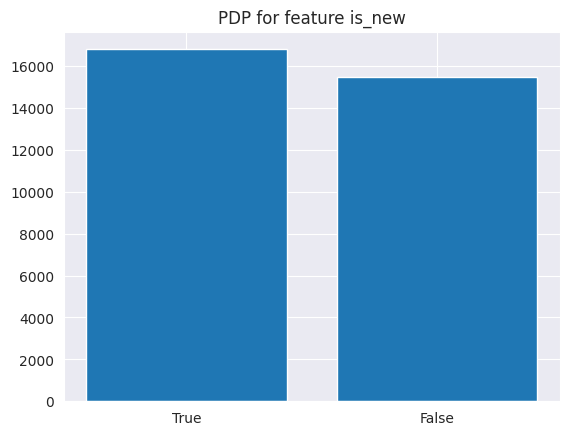

In [122]:
pdp_cat(X_test_for_pred, 'is_new', catboost)

In [124]:
list(train.brand.unique())

['audi',
 'skoda',
 'toyota',
 'opel',
 'nissan',
 'suzuki',
 'volkswagen',
 'fiat',
 'renault',
 'ford',
 'citroen',
 'alfa romeo',
 'land rover',
 'isuzu',
 'smart',
 'mercedes-benz',
 'porsche',
 'bmw',
 'hyundai',
 'mitsubishi',
 'daihatsu',
 'peugeot',
 'mazda',
 'seat',
 'jeep',
 'dacia',
 'kia',
 'rover',
 'tesla',
 'volvo',
 'honda',
 'mini',
 'lynk&co',
 'maserati',
 'abarth',
 'daewoo',
 'subaru',
 'chevrolet',
 'lancia',
 'ssangyong',
 'mg',
 'jaguar',
 'ds',
 'bentley',
 'lamborghini',
 'saab',
 'mclaren',
 'dfsk',
 'iveco',
 'aixam',
 'piaggio',
 'dodge',
 'lexus',
 'cadillac',
 'lada',
 'byd',
 'gmc',
 'ferrari',
 'cupra',
 'ecocar',
 'xev',
 'aston martin',
 'chrysler',
 'leapmotor',
 'hummer',
 'infiniti',
 'corvette',
 'lotus',
 'china-motors']

In [128]:
dict_cars = train.groupby('brand')['model'].agg(lambda x: list(x.unique())).to_dict()

In [134]:
import pickle

with open('../data/car_dictionary.pkl', 'wb') as f:
    pickle.dump(dict_cars, f)

In [188]:
X_test_for_pred['extra_aircondition(a_c)'].iloc[0]

False

In [132]:
train.engine_power.describe()

count    81141.000000
mean       136.243930
std         82.923402
min          0.000000
25%         90.000000
50%        115.000000
75%        150.000000
max        999.000000
Name: engine_power, dtype: float64

In [137]:
list_fuel_types = list(train.fuel_type.unique())

with open('../data/list_fuel_types.pkl', 'wb') as f:
    pickle.dump(list_fuel_types, f)


In [138]:
list_fuel_types

['plug_in_hybrid_petrol',
 'diesel',
 'petrol',
 'lpg',
 'hybrid_petrol',
 'hybrid_diesel',
 'electric',
 'cng',
 'plug_in_hybrid_diesel',
 'other',
 'hydrogen']

In [139]:
list_gearbox_type= list(train.gearbox_type.unique())

with open('../data/list_gearbox_type.pkl', 'wb') as f:
    pickle.dump(list_gearbox_type, f)


In [140]:
list_gearbox_type

['automatic', 'manual', 'semi_automatic']

In [179]:
list((train.drive_type
.unique()))

['FWD', nan, '4WD', 'RWD', 'AWD']

In [165]:
list(train.wheelbase.unique())

[nan,
 2470.0,
 2465.0,
 2685.0,
 2525.0,
 2530.0,
 2510.0,
 2646.0,
 2340.0,
 2880.0,
 2873.0,
 2539.0,
 2699.0,
 2660.0,
 2385.0,
 2450.0,
 2601.0,
 2551.0,
 2540.0,
 2538.0,
 2466.0,
 2670.0,
 2613.0,
 2493.0,
 2578.0,
 2430.0,
 2855.0,
 2675.0,
 2604.0,
 2703.0,
 2575.0,
 2486.0,
 3000.0,
 2460.0,
 2580.0,
 2810.0,
 2489.0,
 2570.0,
 2400.0,
 2637.0,
 2669.0,
 2380.0,
 2583.0,
 2577.0,
 3300.0,
 2492.0,
 2680.0,
 1873.0,
 2793.0,
 2634.0,
 2606.0,
 2589.0,
 2511.0,
 2620.0,
 2568.0,
 1812.0,
 2770.0,
 2300.0,
 2888.0,
 1867.0,
 2667.0,
 2776.0,
 2420.0,
 2923.0,
 2630.0,
 2360.0,
 2650.0,
 2605.0,
 2595.0,
 2702.0,
 2729.0,
 2600.0,
 2737.0,
 2648.0,
 2480.0,
 2700.0,
 2500.0,
 2815.0,
 2760.0,
 3098.0,
 2407.0,
 3002.0,
 2200.0,
 2625.0,
 2690.0,
 2933.0,
 2705.0,
 2647.0,
 2730.0,
 2410.0,
 2990.0,
 2560.0,
 2588.0,
 2519.0,
 2712.0,
 2807.0,
 2788.0,
 2964.0,
 2640.0,
 2642.0,
 3220.0,
 2686.0,
 2673.0,
 2874.0,
 2435.0,
 2469.0,
 2641.0,
 2563.0,
 2750.0,
 2780.0,
 2636.0,
 249

In [176]:
train.loc[train.fuel_consumption.notna(),'fuel_consumption'].astype(float)

ValueError: could not convert string to float: '5,50'

In [154]:
train.vehicle_height.describe()

count    46821.000000
mean      1761.044745
std         79.993370
min       1475.000000
25%       1722.000000
50%       1765.000000
75%       1810.000000
max       2073.000000
Name: vehicle_height, dtype: float64

In [178]:
train_val.loc[train_val.fuel_consumption.notna(),'fuel_consumption'].describe()

count    42186.000000
mean         5.539023
std          1.811266
min          0.500000
25%          4.300000
50%          5.100000
75%          6.400000
max         36.000000
Name: fuel_consumption, dtype: float64

In [180]:
X_test_for_pred.iloc[0].to_dict()

{'lat': 37.9677948168,
 'lon': 23.6177911107,
 'is_new': False,
 'mileage': 30000.0,
 'crashed': False,
 'engine_size': 1968.0,
 'registration_month': 1,
 'registration_year': 2022.0,
 'engine_power': 205.0,
 'fuel_type': 'hybrid_diesel',
 'gearbox_type': 'automatic',
 'brand': 'audi',
 'model': 'a4',
 'extra_turbo': True,
 'extra_steering_lights': True,
 'extra_collision_avoidance_system': True,
 'extra_trip_computer': True,
 'extra_wheelchair': False,
 'extra_apple_carplay': True,
 'extra_leather_seats': False,
 'extra_anti_theft_system_gps': False,
 'extra_rain_sensor': True,
 'extra_panoramic_roof': False,
 'extra_dvd': True,
 'extra_automatic_parking': False,
 'extra_multi_purpose_steering_wheel': True,
 'extra_tcs_asr': True,
 'extra_tv_camera': False,
 'extra_power_windows': True,
 'extra_bucket_seats': True,
 'extra_hitch': False,
 'extra_aircondition(a_c)': False,
 'extra_heated_seats': False,
 'extra_power_seats': False,
 'extra_alumium_rims': True,
 'extra_locking_differenti

In [191]:
X_test_for_pred.columns

Index(['lat', 'lon', 'is_new', 'mileage', 'crashed', 'engine_size',
       'registration_month', 'registration_year', 'engine_power', 'fuel_type',
       'gearbox_type', 'brand', 'model', 'extra_turbo',
       'extra_steering_lights', 'extra_collision_avoidance_system',
       'extra_trip_computer', 'extra_wheelchair', 'extra_apple_carplay',
       'extra_leather_seats', 'extra_anti_theft_system_gps',
       'extra_rain_sensor', 'extra_panoramic_roof', 'extra_dvd',
       'extra_automatic_parking', 'extra_multi_purpose_steering_wheel',
       'extra_tcs_asr', 'extra_tv_camera', 'extra_power_windows',
       'extra_bucket_seats', 'extra_hitch', 'extra_aircondition(a_c)',
       'extra_heated_seats', 'extra_power_seats', 'extra_alumium_rims',
       'extra_locking_differential', 'extra_android_auto', 'extra_roof_rails',
       'extra_armored', 'extra_lane_assist', 'never_crashed',
       'extra_immobilizer', 'extra_rear_view_camera', 'extra_air_suspension',
       'extra_bluetooth', 'ext